# Diversity of handwriting styles at The Alan Turing Institute

During National Inclusion Week, we collected samples of handwriting styles across the Institute of the phrase _Each One Reach One_, the theme of the week.
Just as various groups and characteristics exist within the Institute that people might not always be aware of, we were interested in exploring and visualising different styles of handwriting that might exist.

We utilise encodings from a convolutional autoencoder trained on the data to compute a representation of each sample that might be indicative of style.
We then use dimensionality reduction algorithms to explore and visualise similarities that exist amongst the writing samples.

## Load and organise the data

For performing the analysis below, permission was obtained from any participants submitting a handwriting sample.
The raw anonymised data is stored internally and not publically available.

In [1]:
# Processing
import glob
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

import numpy as np
from skimage.filters import threshold_otsu, gaussian

# Model
import tensorflow as tf
print("tf version", tf.__version__)

# Plotting
import matplotlib.pyplot as plt

tf version 2.3.0-rc0


In [2]:
# In their original form the images are ~1000 tall by ~4000 pixels wide
HEIGHT, WIDTH = 100, 400

In [3]:
# Load images and resize them
data_dir = "data"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode=None,
    color_mode="rgb",
    image_size=(HEIGHT, WIDTH), # (H, W)
    batch_size=1,
    shuffle=False
) # Returns a sequence of images of shape (1, H, W, 3)
print(f"Expected {len(glob.glob(data_dir + '/samples/*'))} samples.")

dataset = dataset.map(lambda x: tf.squeeze(x, axis=0)/255) # (H, W, 3)
dataset

Found 32 files belonging to 1 classes.
Expected 32 samples.


<MapDataset shapes: (100, 400, 3), types: tf.float32>

We'll also train on some classical fonts too, such as Times New Roman, to see whether any styles align closely with them too.

In [4]:
# Augment the data with some classical fonts
# Get truetype font files available
font_files = glob.glob("fonts/*/*.ttf") + glob.glob("fonts/*/*.ttc")
print(f"Found {len(font_files)} font(s).")

# Dir to save font files to
Path("font_images/samples").mkdir(parents=True, exist_ok=True)

# Create image data file of each available font
for i, file in enumerate(font_files):
    img = Image.new("RGB", (4000, 1000), color="white")
    if "small" in file:
        size = 600 # Some fonts are naturally smaller
    else:
        size = 400
    fnt = ImageFont.truetype(file, size)
    d = ImageDraw.Draw(img)
    d.text((100,200), "Each One Reach One", font=fnt, fill="black")
    img.save(f"font_images/samples/{Path(file).stem}.png")

Found 38 font(s).


In [5]:
# Load newly created classical fonts
fonts_dir = "font_images"
fonts_ds = tf.keras.preprocessing.image_dataset_from_directory(
    fonts_dir,
    label_mode=None,
    color_mode="rgb",
    image_size=(HEIGHT, WIDTH), # (H, W)
    batch_size=1,
    shuffle=False
) # Returns a sequence of images of shape (1, H, W, 3)
print(f"Expected {len(glob.glob(fonts_dir + '/samples/*'))} samples.")

fonts_ds = fonts_ds.map(lambda x: tf.squeeze(x, axis=0)/255) # (H, W, 3)
fonts_ds

Found 38 files belonging to 1 classes.
Expected 38 samples.


<MapDataset shapes: (100, 400, 3), types: tf.float32>

In [6]:
# Concatenate datasets
augmented_ds = dataset.concatenate(fonts_ds)
augmented_ds

<ConcatenateDataset shapes: (100, 400, 3), types: tf.float32>

In [7]:
def display_samples(tf_dataset, num_display=12, num_columns=3, figsize=(16,6)):
    """Display image samples in an unbatched TensorFlow Dataset."""
    plt.figure(figsize=figsize)
    for i, image in tf_dataset.enumerate():
        i = i.numpy()
        if i >= num_display:
            break
        
        plt.subplot(np.ceil(num_display/num_columns), num_columns, i + 1)
        plt.imshow(image.numpy(), cmap="gray" if len(image.numpy().shape) == 2 else None)
        plt.axis("off")

Samples:


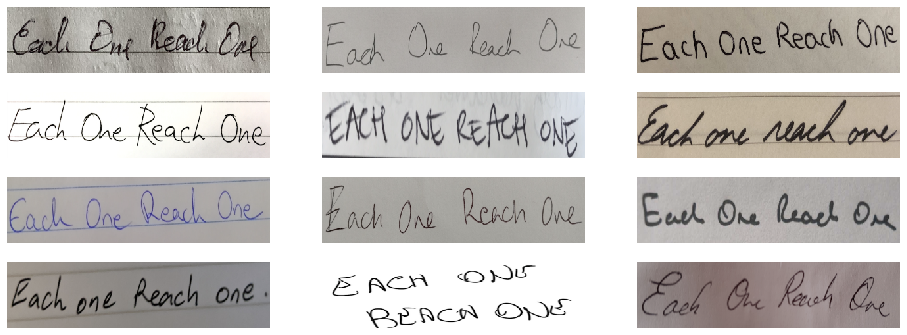

In [8]:
# Visualise some of the original samples
print("Samples:")
display_samples(augmented_ds)

We have currently loaded the images with their colour channels RGB. 
In the context of identifying pure style of the writing samples we're less interested in the colour channels, especially as they add extra dimensionality to the data.

HSV converted samples:


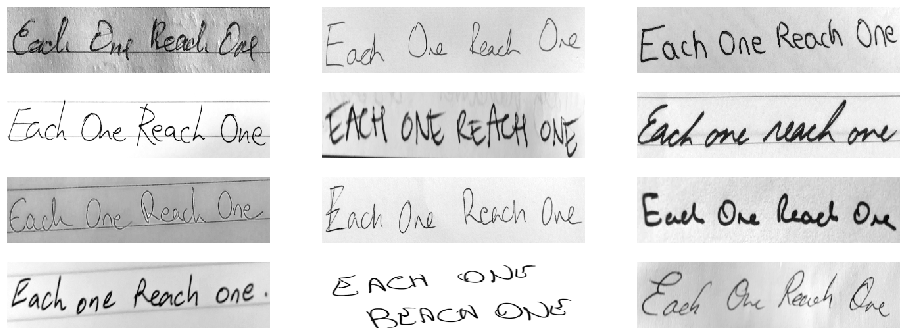

In [9]:
# Convert to HSV (hue, saturation, value) and take 'value' (brightness) channel
hsv_ds = augmented_ds.map(lambda x: tf.image.rgb_to_hsv(x)[..., 2])
print("HSV converted samples:")
display_samples(hsv_ds)

In order to minimise the influence of the different lighting conditions, we'll apply a thresholding algorithm to separate the background from the foreground and return each pixel as purely white or black respectively. In this case, we'll use *Otsu's method for thresholding*.

Thresholded samples:


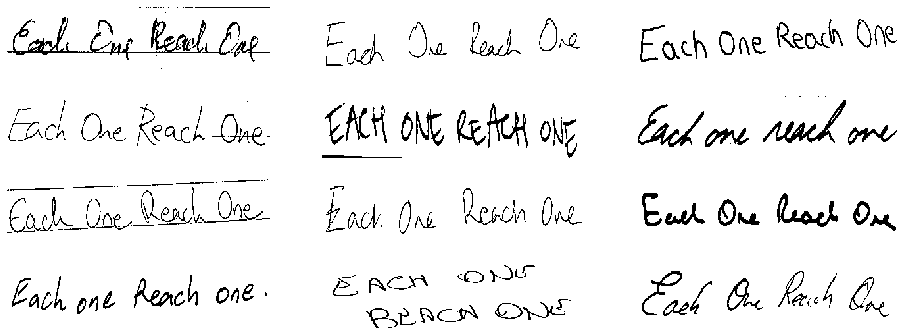

In [10]:
# Minimise the influence of the background lighting conditions
np_thresholded_ds = [image > threshold_otsu(image.numpy()) for image in hsv_ds]
thresholded_ds = tf.data.Dataset.from_tensor_slices(np_thresholded_ds)
print("Thresholded samples:")
display_samples(thresholded_ds)

## Build and train an autoencoder

In [11]:
import math
import tensorflow_addons as tfa

def augment_image(img):
    """Return image with rotations, translations and blur applied randomly."""
    # Randomly add small rotations of +- 10 deg to the image
    augmented_img = tfa.image.rotate(img, tf.random.uniform([], minval=-10*math.pi/180, maxval=10*math.pi/180))
    
    # Randomly translate the image (move image around)
    augmented_img = tfa.image.translate(augmented_img, tf.random.uniform([2], minval=-10, maxval=11)) # [minval, maxval)
    
    # Randomly add blur to larger images (blur removes thinner writing styles)
    apply_blur = tf.random.uniform([])
    augmented_img = tf.where(tf.math.logical_and(apply_blur > 0.5, tf.reduce_sum(augmented_img) > 3000),
                             tfa.image.mean_filter2d(augmented_img, filter_shape=2, padding="CONSTANT", constant_values=0),
                             augmented_img
                            )
    return augmented_img

def prepare(p_ds, batch_size=32, shuffle=False, augment=False):
    """Augment, shuffle and batch a TensorFlow Dataset."""
    # Use data augmentation only on the training set
    if augment:
        aug_ds = p_ds.map(lambda x: augment_image(x))
        p_ds = p_ds.concatenate(aug_ds)
        
    if shuffle:
        p_ds = p_ds.shuffle(buffer_size=160) # Buffer size > num data points
    
    p_ds = p_ds.batch(batch_size)
    return p_ds

In [12]:
# Cast boolean threshold to int values, and invert (some augmentations fill space with zeros)
int_thresholded_ds = thresholded_ds.map(lambda x: 1-tf.cast(x, tf.dtypes.int32))

# Augment the dataset with rotations, translations and blur
train_ds = prepare(int_thresholded_ds, shuffle=True, augment=True)
print(train_ds)

# Keras fit expects a tuple of (x, y)
tuple_ds = train_ds.map(lambda x: (tf.expand_dims(x, -1), tf.expand_dims(x, -1)))
print(tuple_ds)

<BatchDataset shapes: (None, 100, 400), types: tf.int32>
<MapDataset shapes: ((None, 100, 400, 1), (None, 100, 400, 1)), types: (tf.int32, tf.int32)>


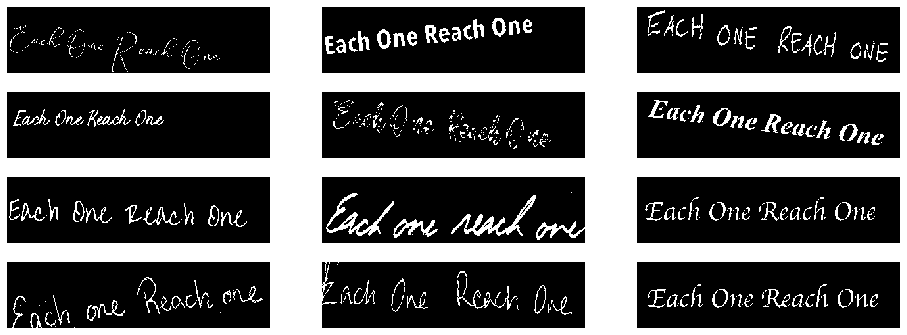

In [13]:
# Show samples of training data
display_samples(train_ds.unbatch())

In [14]:
from tensorflow.keras import layers, models
tf.keras.backend.clear_session()

# A simple convolutional autoencoder

input_img = layers.Input(shape=(HEIGHT, WIDTH, 1))

# Encoder
h = layers.Conv2D(16, (12,12), strides=(2,2), activation="relu", padding="same", data_format="channels_last")(input_img)
h = layers.MaxPooling2D((2,2), padding="same", data_format="channels_last")(h)
h = layers.Conv2D(12, (5,5), strides=(5,5), activation="relu", padding='same', data_format="channels_last")(h)
encoded = layers.MaxPooling2D((5,5), padding="same", data_format="channels_last")(h)

# At this point, the representation is 1*4*12 (48) dimensional

# Decoder
h = layers.Conv2DTranspose(12, (5,5), strides=(5,5), activation="relu", padding="same", data_format="channels_last")(encoded)
h = layers.UpSampling2D((5,5))(h)
h = layers.Conv2DTranspose(16, (6,6), activation="relu", padding="same", data_format="channels_last")(h)
h = layers.UpSampling2D((4,4))(h)
decoded = layers.Conv2D(1, (6,6), activation="sigmoid", padding="same", data_format="channels_last")(h)

# Create a separate component to map an image to its encoded representation
encoder = models.Model(input_img, encoded)

# Compile model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy") # predicting 0s or 1s
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 400, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 200, 16)       2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 100, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 20, 12)         4812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 4, 12)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 20, 12)         3612      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 25, 100, 12)      

In [15]:
# Train the model on the data and follow the training loss
history = autoencoder.fit(tuple_ds,
                          epochs=100,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, mode="min")]
                         )

Epoch 1/100
5/5 [==============================] - 4s 739ms/step - loss: 0.6880
Epoch 2/100
5/5 [==============================] - 4s 736ms/step - loss: 0.6238
Epoch 3/100
5/5 [==============================] - 4s 781ms/step - loss: 0.4116
Epoch 4/100
5/5 [==============================] - 4s 748ms/step - loss: 0.3451
Epoch 5/100
5/5 [==============================] - 4s 744ms/step - loss: 0.2908
Epoch 6/100
5/5 [==============================] - 4s 749ms/step - loss: 0.2753
Epoch 7/100
5/5 [==============================] - 4s 752ms/step - loss: 0.2580
Epoch 8/100
5/5 [==============================] - 4s 741ms/step - loss: 0.2590
Epoch 9/100
5/5 [==============================] - 4s 757ms/step - loss: 0.2481
Epoch 10/100
5/5 [==============================] - 4s 764ms/step - loss: 0.2449
Epoch 11/100
5/5 [==============================] - 4s 757ms/step - loss: 0.2388
Epoch 12/100
5/5 [==============================] - 4s 763ms/step - loss: 0.2382
Epoch 13/100
5/5 [===================

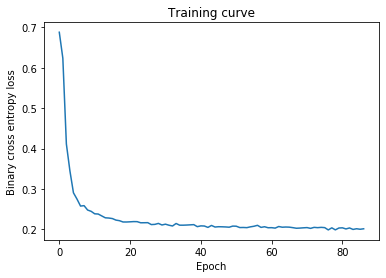

In [16]:
# Plot the training curve
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Binary cross entropy loss")
plt.title("Training curve")
plt.show()

In [17]:
def sample_reconstructions(tf_dataset_target, tf_dataset_pred, num_display_pairs=5, figsize=(16,12)):
    """Compare target samples and predicted reconstructions in TensorFlow Datasets (with batch size 1)."""
    plt.figure(figsize=figsize)
    num_columns = 2 # Compare target and prediction side by side
    num_display = num_display_pairs * num_columns
    for (i, target_img), (j, pred_img) in zip(tf_dataset_target.enumerate(), x_pred_ds.enumerate()):

        i, j = i.numpy(), j.numpy()
        if (i + j + 1) >= num_display:
            break

        plt.subplot(np.ceil(num_display/num_columns), num_columns, (i + j + 1))
        plt.imshow(target_img.numpy(), cmap="gray")
        plt.axis("off")
        plt.title("Input ({})".format(i))

        plt.subplot(np.ceil(num_display/num_columns), num_columns, (i + j + 2))
        plt.imshow(pred_img.numpy(), cmap="gray")
        plt.axis("off")
        plt.title("Reconstruction ({})".format(i))

In [18]:
# Target images
target_ds = int_thresholded_ds.batch(1) # int_thresholded_ds (H x W), target_ds (None x H x W)

# Predicted reconstruction
x_pred = autoencoder.predict(target_ds) # x_pred (N x H x W x 1)
x_pred_ds = tf.data.Dataset.from_tensor_slices(np.squeeze(x_pred)) # x_pred_ds (H X W)

# Target reconstruction for plotting
# target_ds_for_plotting = target_ds.map(lambda x: tf.squeeze(x, axis=0)) # target_ds (H X W)
# sample_reconstructions(target_ds_for_plotting, x_pred_ds)

## Find groups within the embedded samples

In [19]:
# Get encoded representation of each sample from the autoencoder's encoder.
encodings = encoder.predict(target_ds) # (N x E)
encodings_rs = encodings.reshape(encodings.shape[0], 1*4*12)

In [20]:
# t-SNE
from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components=2, perplexity=18).fit_transform(encodings_rs) # (N x 2)

# UMAP https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap.umap_ as umap
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(encodings_rs) # (N x 2)

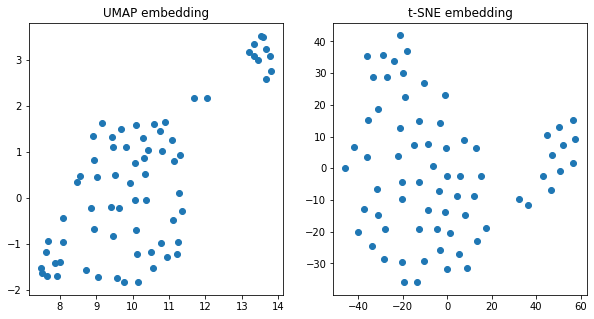

In [21]:
# Plot embedding
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
ax1.set_title("UMAP embedding")
ax2.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])
ax2.set_title("t-SNE embedding")
plt.show()

In [22]:
# Colour points according to partitions identified by clustering algorithms
from sklearn.cluster import KMeans

# Number of clusters determined by optimising Silhoutte Score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
tsne_kmeans_labels = KMeans(10).fit(tsne_embedding).labels_
umap_kmeans_labels = KMeans(10).fit(umap_embedding).labels_

## Create visualisation

We will use Python libraries [Bokeh](https://docs.bokeh.org/en/latest/index.html) and [Jinja2](https://jinja.palletsprojects.com/en/2.11.x/) to create a simple portable HTML page to visualise the findings.

In [23]:
# Image processing
import io
import base64
import PIL

from skimage import img_as_ubyte

# HTML visualisation
import jinja2
from bokeh.plotting import figure, ColumnDataSource
from bokeh.resources import CDN
from bokeh.models import HoverTool, CustomJS, WheelZoomTool, LassoSelectTool
from bokeh.embed import components, file_html
from bokeh.models.widgets import RadioButtonGroup

In [24]:
# Prepare images of handwriting for Bokeh's hover tool
def to_png(img):
    """Return png format of image."""
    out = io.BytesIO()
    im = PIL.Image.fromarray(img)
    im.save(out, format='png')
    return out.getvalue()

urls = ["data:image/png;base64," + base64.b64encode(to_png(img_as_ubyte(image.numpy()))).decode("utf-8") for image in thresholded_ds]

In [25]:
# Create colour map for tsne and umap labels
colors = ["#f85959","#ffbc69","#fbff7b","#91ff7b","#65f2ff","#65a0ff","#FFACFF","#4293DE","#296EB4","#399E5A","#429EA6"]
cmap = {i: c for i, c in enumerate(colors)}
tsne_clabels = [cmap[i] for i in tsne_kmeans_labels]
umap_clabels = [cmap[i] for i in umap_kmeans_labels]

In [26]:
# Each data source contains the embeddings for a particular algorithm and original images
tsne_data = dict(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], imgs=urls, color_labels=tsne_clabels)
umap_data = dict(x=umap_embedding[:, 0], y=umap_embedding[:, 1], imgs=urls, color_labels=umap_clabels)
source = ColumnDataSource(data=umap_data)

# Show original image on hover
hover = HoverTool(tooltips="""<img src="@imgs" height="100" alt="@imgs" width="400"></img>""")

# Construct figure
p = figure(sizing_mode="stretch_both",
           height_policy="auto",
           min_height=575,
           tools=[hover,"pan","reset","wheel_zoom"]
          )
p.scatter("x", "y", size=20, source=source, color="color_labels")

# Extra options for figure formatting
p.toolbar.active_scroll = p.select_one(WheelZoomTool) # Enable on default

# Switch between algorithms
callback_code = """p.reset.emit(); if(cb_obj.active == 1) source.data = tsne_data; else source.data=umap_data;"""
callback = CustomJS(args={"source": source, 
                          "umap_data": umap_data, 
                          "tsne_data": tsne_data, 
                          "p": p},
                    code=callback_code
                   )
buttons = RadioButtonGroup(labels=["umap", "tsne"], active=0, css_classes=["overlay_buttons"])
buttons.js_on_change("active", callback)

# Inject Bokeh visualisation into Jinja template
env = jinja2.Environment(loader=jinja2.FileSystemLoader("templates"))
template = env.get_template("index.html")
html = file_html([p, buttons, buttons], CDN, title="Turing Handwriting Styles", template=template)

# Save html to file
with open("handwriting.html", "w") as outf:
    outf.write(html)

In [1]:
# from IPython.display import IFrame

# # To render in Jupyter
# IFrame(src="./handwriting.html", width=950, height=650)